# Learning to stabilize a double inverted pendulum

**Differentiable Predictive Control method**:  
The DPC is a model-based policy optimization algorithm, that exploits the differentiability of a wide class of model representations for dynamical systems, including differential equations, state-space models, or various neural network architectures. In DPC, we construct a differentiable closed-loop system composed of neural control policy and system dynamics model that is to be optimized using parametric control objectives as intrinsic reward signals evaluated over a sampled distribution of the problem parameters.

## NeuroMANCER and Dependencies

### Install (Colab only)
Skip this step when running locally.

In [ ]:
!pip install neuromancer
from soap import SOAP

In [2]:
loss_fn = "prob"

In [3]:
import torch
from neuromancer.system import Node, System
from neuromancer.modules import blocks
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable, Objective
from neuromancer.loss import PenaltyLoss, AggregateLoss
from neuromancer.problem import Problem
from neuromancer.trainer import Trainer
from neuromancer.dynamics import integrators

import matplotlib.pyplot as plt

In [4]:
from dip import DoubleInvertedPendulum

# Node and System classes

The Node class is a simple wrapper for any callable pytorch function or nn.Module which provides names for the inputs and outputs to be used in composition of a potentially cyclic computational graph.  

In [ ]:
constrained_action = True
gamma = 1.0

nsteps = 75
lr = 0.003
opt = 'soap' # 'adam' or 'soap' 
loss = 'gc' # 'gc' or 'l2'
constrained_pos = True

# gamma_next = lambda x: x*gamma
gamma_dynamics = Node(lambda x: x*gamma, ['gamma'], ['gamma'])

nx, nu = 6, 1

ts = 0.05

# white-box ODE model with no-plant model mismatch
gt_ode = DoubleInvertedPendulum()                   # ODE system equations implemented in PyTorch

# integrate continuous time ODE
integrator = integrators.RK4_Trap(gt_ode, h=torch.tensor(ts))   # RK4, RK4_Trap, Runge_Kutta_Fehlberg, LeapFrog

dynamics = Node(integrator, ['X', 'U'], ['X'], name='model')

observation = Node(lambda x: 1.0 - torch.cos(x[:,1:3]), ['X'], ['Y'])

# linear state space model
std = 0.1


In [6]:
if loss == 'gc':
    prob = lambda x, g: -g*torch.exp(-0.5*(x**2).sum(axis=1, keepdims=True) / 0.5**2) / nsteps
elif loss == 'l2':
    prob = lambda x, g: g*0.5*(x**2).sum(axis=1, keepdims=True) / nsteps
cost = Node(prob, ['Y', 'gamma'], ['l'])

if constrained_action:
    mlp = blocks.MLP_bounds(nx, nu, bias=True,
                    linear_map=torch.nn.Linear,
                    nonlin=torch.nn.GELU,
                    min = -10.0, max = 10.0,
                    hsizes=[256, 256]) # [256, 256] & GELU is nice and smooth
else:
    mlp = blocks.MLP(nx, nu, bias=True,
                    linear_map=torch.nn.Linear,
                    nonlin=torch.nn.SiLU,
                    hsizes=[64, 64])

policy = Node(mlp, ['X'], ['U'], name='policy')

# closed loop system definition
cl_system = System([policy, dynamics, observation, gamma_dynamics, cost], nsteps=nsteps)

# Training dataset generation

In [7]:
# Training dataset generation

samples = 100000
split = int(samples*1.0)
dev_samples = 10000
td = torch.zeros((samples, 1, nx))
td[0:split,:,1:3] = torch.pi #* (torch.rand_like(td[0:split,:,1:3])*0.2 + 0.9)


dev_td = torch.zeros((dev_samples, 1, nx))
dev_td[:,:,1:3] = torch.pi

train_data = DictDataset({'X': 0.1*torch.randn((samples, 1, nx)) + td, 'gamma': torch.ones(samples, 1, 1)}, name='train')  # Split conditions into train and dev
# train_data['X'][:,:,1:3] = torch.pi
dev_data = DictDataset({'X': 0.1*torch.randn((dev_samples, 1, nx)) + dev_td, 'gamma': torch.ones(dev_samples, 1, 1)}, name='dev')
# dev_data['X'][:,:,1:3] = torch.pi

train_loader = torch.utils.data.DataLoader(train_data, batch_size=2048,
                                           collate_fn=train_data.collate_fn, shuffle=True)
dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=2048,
                                         collate_fn=dev_data.collate_fn, shuffle=True)

# Optimization problem

In [8]:
class LogLoss(AggregateLoss):
    """
    Penalty loss function.
        https://en.wikipedia.org/wiki/Penalty_method
    """

    def __init__(self, objectives, constraints):
        """
        :param objectives: (list (Objective)) list of neuromancer objective classes
        :param constraints: (list (Constraint)) list of neuromancer constraint classes
        """
        super().__init__(objectives, constraints)

    def forward(self, input_dict):
        """

        :param input_dict: (dict {str: torch.Tensor}) Values from forward pass calculations
        :return: (dict {str: torch.Tensor}) input_dict appended with calculated loss values
        """
        objectives_dict = self.calculate_objectives(input_dict)
        input_dict = {**input_dict, **objectives_dict}
        fx = objectives_dict['objective_loss']
        penalties_dict = self.calculate_constraints(input_dict)
        input_dict = {**input_dict, **penalties_dict}
        penalties = penalties_dict['penalty_loss']
        input_dict['loss'] = -torch.log(-1*fx) + penalties
        return input_dict

In [9]:
# Define optimization problem
u = variable('U')
x = variable('X')

# pos = variable('pos')
pos_max = 5
state_lower_bound_penalty = (1. / nsteps)*(x[0] > -1*pos_max)
state_upper_bound_penalty = (1. / nsteps)*(x[0] < pos_max)

lpred = variable('l')
l_loss = Objective(var=lpred, name='stage_loss')

if constrained_pos:
    constraints = [state_lower_bound_penalty, state_upper_bound_penalty]
else:
    constraints = []

if loss == 'gc':
    obj = LogLoss([l_loss], constraints) # state_lower_bound_penalty, state_upper_bound_penalty
elif loss == 'l2':
    obj = PenaltyLoss([l_loss], constraints) # creating an exponential loss doesn't improve things like the LogLoss above

problem = Problem([cl_system], obj)

if opt == "adam":
    optimizer = torch.optim.AdamW(policy.parameters(), lr=lr)
elif opt == "soap":
    optimizer = SOAP(policy.parameters(), lr=lr) # , lr=0.003

# Optimize problem with a system rollout of 2 time steps


In [ ]:
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    dev_loader,
    optimizer=optimizer,
    epochs=50,
    train_metric="train_loss",
    dev_metric="dev_loss",
    eval_metric='dev_loss',
    warmup=0,
)

best_model = trainer.train()

epoch: 0  train_loss: 10.167830467224121


In [ ]:
if True:
    PATH = f"models/new_policy_{constrained_pos}_{nsteps}_{lr}_{opt}_{loss}_soft.pth" 
    torch.save(mlp.state_dict(), PATH)

    mlp.load_state_dict(torch.load(PATH))

    # Set the model to evaluation mode if you're using it for inference
    mlp.eval() 

# Evaluate best model on a system rollout 


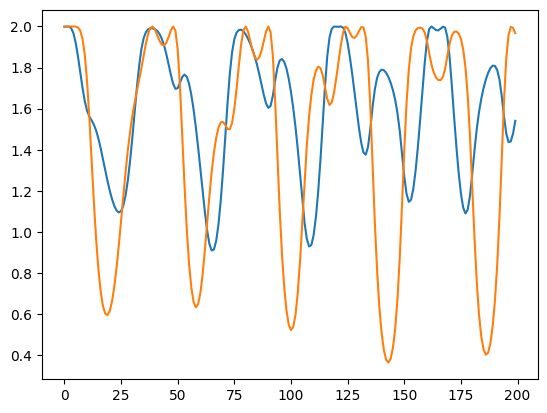

In [12]:
# Test best model with prediction horizon of 50
problem.load_state_dict(best_model)

test = torch.zeros((1, 1, nx))
test[:,:,1:3] = torch.pi #* (torch.rand_like(test[:,:,1:3])*0.2 + 0.9)

data = {'X': 0.1*torch.randn((1, 1, nx)) + test, 'gamma': torch.ones(1, 1, 1, dtype=torch.float32)}
nsteps = 200
cl_system.nsteps = nsteps
trajectories = cl_system(data)
plt.plot(trajectories['Y'].detach().reshape(nsteps,2).numpy())